In [1]:
pip install torch torchvision matplotlib


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

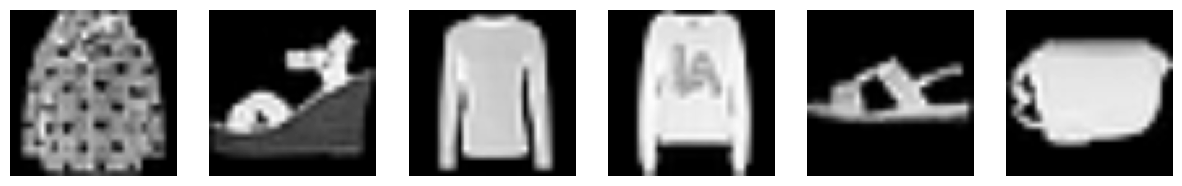

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training data
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Visualize some images
examples = iter(train_loader)
example_data, example_targets = next(examples)  # Use the correct method

# Plot the images
fig, axes = plt.subplots(1, 6, figsize=(15, 15))
for i in range(6):
    axes[i].imshow(example_data[i][0], cmap='gray')
    axes[i].axis('off')
plt.show()



In [2]:
import torch
import torch.nn as nn

# Generator Network
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


100%|██████████| 26421880/26421880 [00:02<00:00, 12852325.14it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 200761.37it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3748841.37it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22970507.44it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
import torch.optim as optim

# Hyperparameters
z_dim = 100
image_dim = 64 * 64
num_epochs = 200
learning_rate = 0.0002

# Initialize models
generator = Generator(z_dim, image_dim).cuda()
discriminator = Discriminator(image_dim).cuda()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()

# Training loop
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        batch_size = real_images.size(0)
        real_images = real_images.view(batch_size, -1).cuda()

        # Labels
        real_labels = torch.ones(batch_size, 1).cuda()
        fake_labels = torch.zeros(batch_size, 1).cuda()

        # Train Discriminator
        optimizer_D.zero_grad()

        # Real images
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Fake images
        z = torch.randn(batch_size, z_dim).cuda()
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)

        g_loss.backward()
        optimizer_G.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

# Save the models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


Epoch [1/200], d_loss: 0.4116, g_loss: 2.7747, D(x): 0.85, D(G(z)): 0.11
Epoch [2/200], d_loss: 0.4485, g_loss: 3.0067, D(x): 0.83, D(G(z)): 0.10
Epoch [3/200], d_loss: 0.5164, g_loss: 2.2943, D(x): 0.82, D(G(z)): 0.17
Epoch [4/200], d_loss: 0.8425, g_loss: 1.0822, D(x): 0.68, D(G(z)): 0.20
Epoch [5/200], d_loss: 0.5633, g_loss: 2.0776, D(x): 0.79, D(G(z)): 0.20
Epoch [6/200], d_loss: 0.9050, g_loss: 2.0995, D(x): 0.74, D(G(z)): 0.36
Epoch [7/200], d_loss: 0.9546, g_loss: 1.7136, D(x): 0.61, D(G(z)): 0.29
Epoch [8/200], d_loss: 1.0142, g_loss: 1.1495, D(x): 0.57, D(G(z)): 0.27
Epoch [9/200], d_loss: 1.4758, g_loss: 1.5418, D(x): 0.53, D(G(z)): 0.39
Epoch [10/200], d_loss: 1.1550, g_loss: 1.2879, D(x): 0.57, D(G(z)): 0.38
Epoch [11/200], d_loss: 1.1487, g_loss: 1.5822, D(x): 0.57, D(G(z)): 0.38
Epoch [12/200], d_loss: 1.3246, g_loss: 1.1385, D(x): 0.53, D(G(z)): 0.42
Epoch [13/200], d_loss: 1.3351, g_loss: 1.4534, D(x): 0.58, D(G(z)): 0.48
Epoch [14/200], d_loss: 1.2998, g_loss: 1.2954,

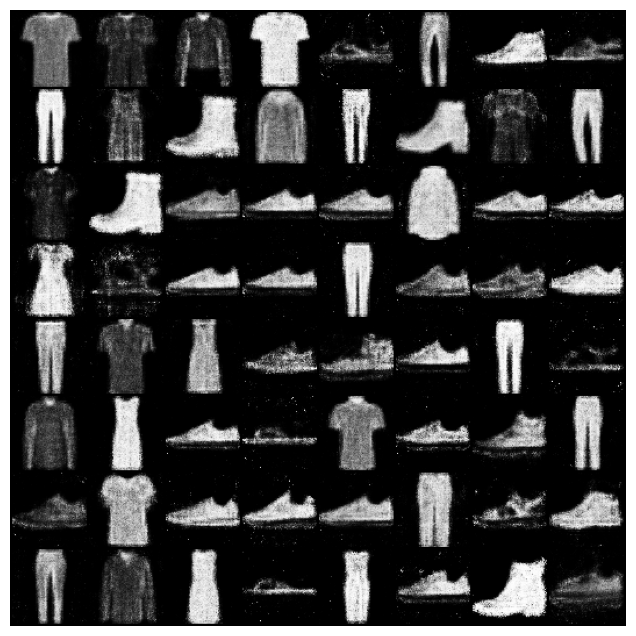

In [5]:
import matplotlib.pyplot as plt
import torchvision

# Load the trained generator
generator.load_state_dict(torch.load('generator.pth'))
generator.eval()

# Generate images
with torch.no_grad():
    z = torch.randn(64, z_dim).cuda()
    fake_images = generator(z).view(-1, 1, 64, 64).cpu()

# Plot the generated images
grid = torchvision.utils.make_grid(fake_images, nrow=8, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()
